#Neural Machine Translation


---








#Introduction

###Overview

I used a sequence to sequence language translation model where, a sequence of words in one language goes into the model, and then the model outputs a sequence of words in a different language, as seen below.

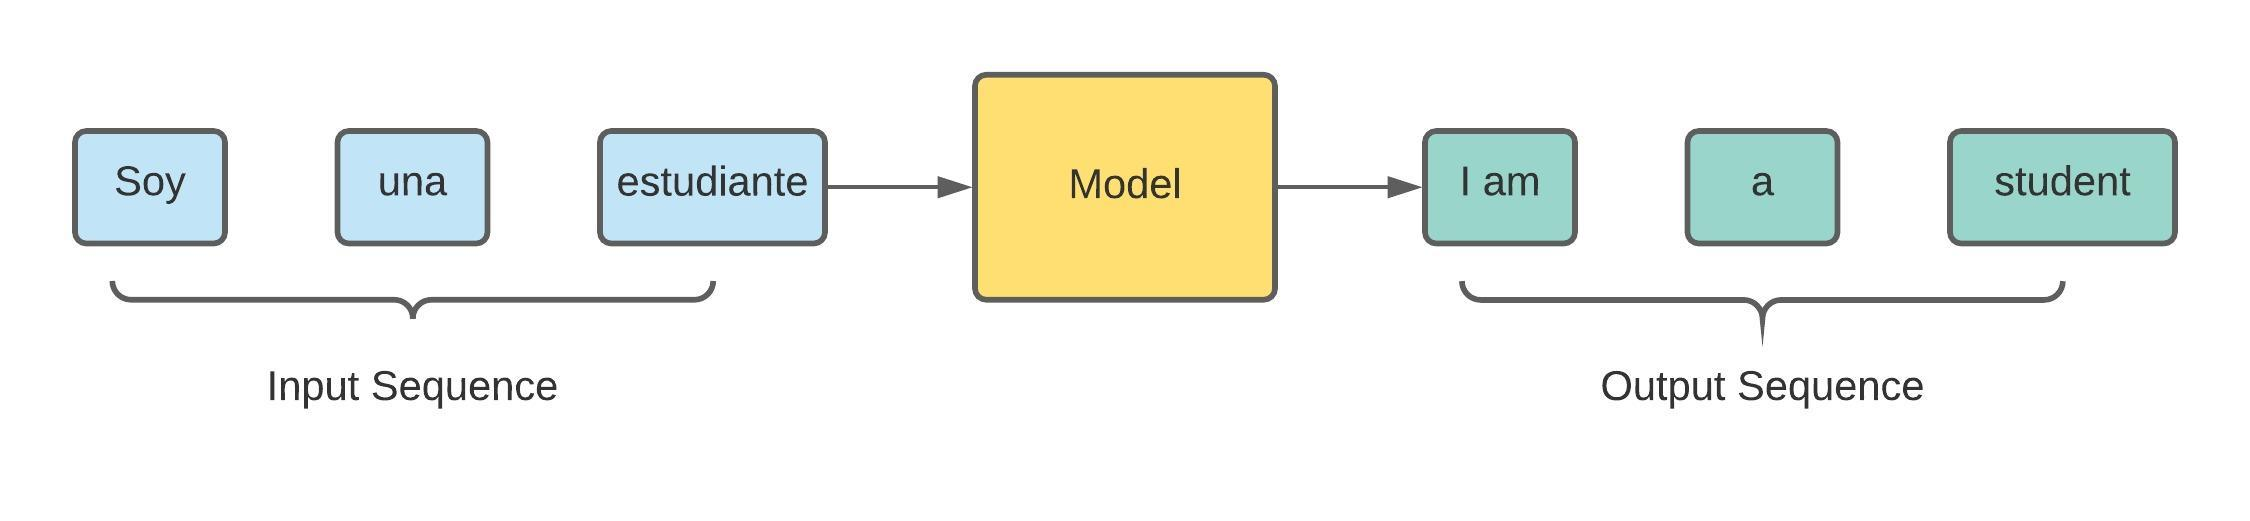

The sequence to sequence model is implemented via a neural network compromised of two recurrent neural networks. The first recurrent neural network is the encoder, and the second is the decoder. A sequence of words is fed into the encoder, and then its output is fed into the decoder. The result is the translated sequence of words.

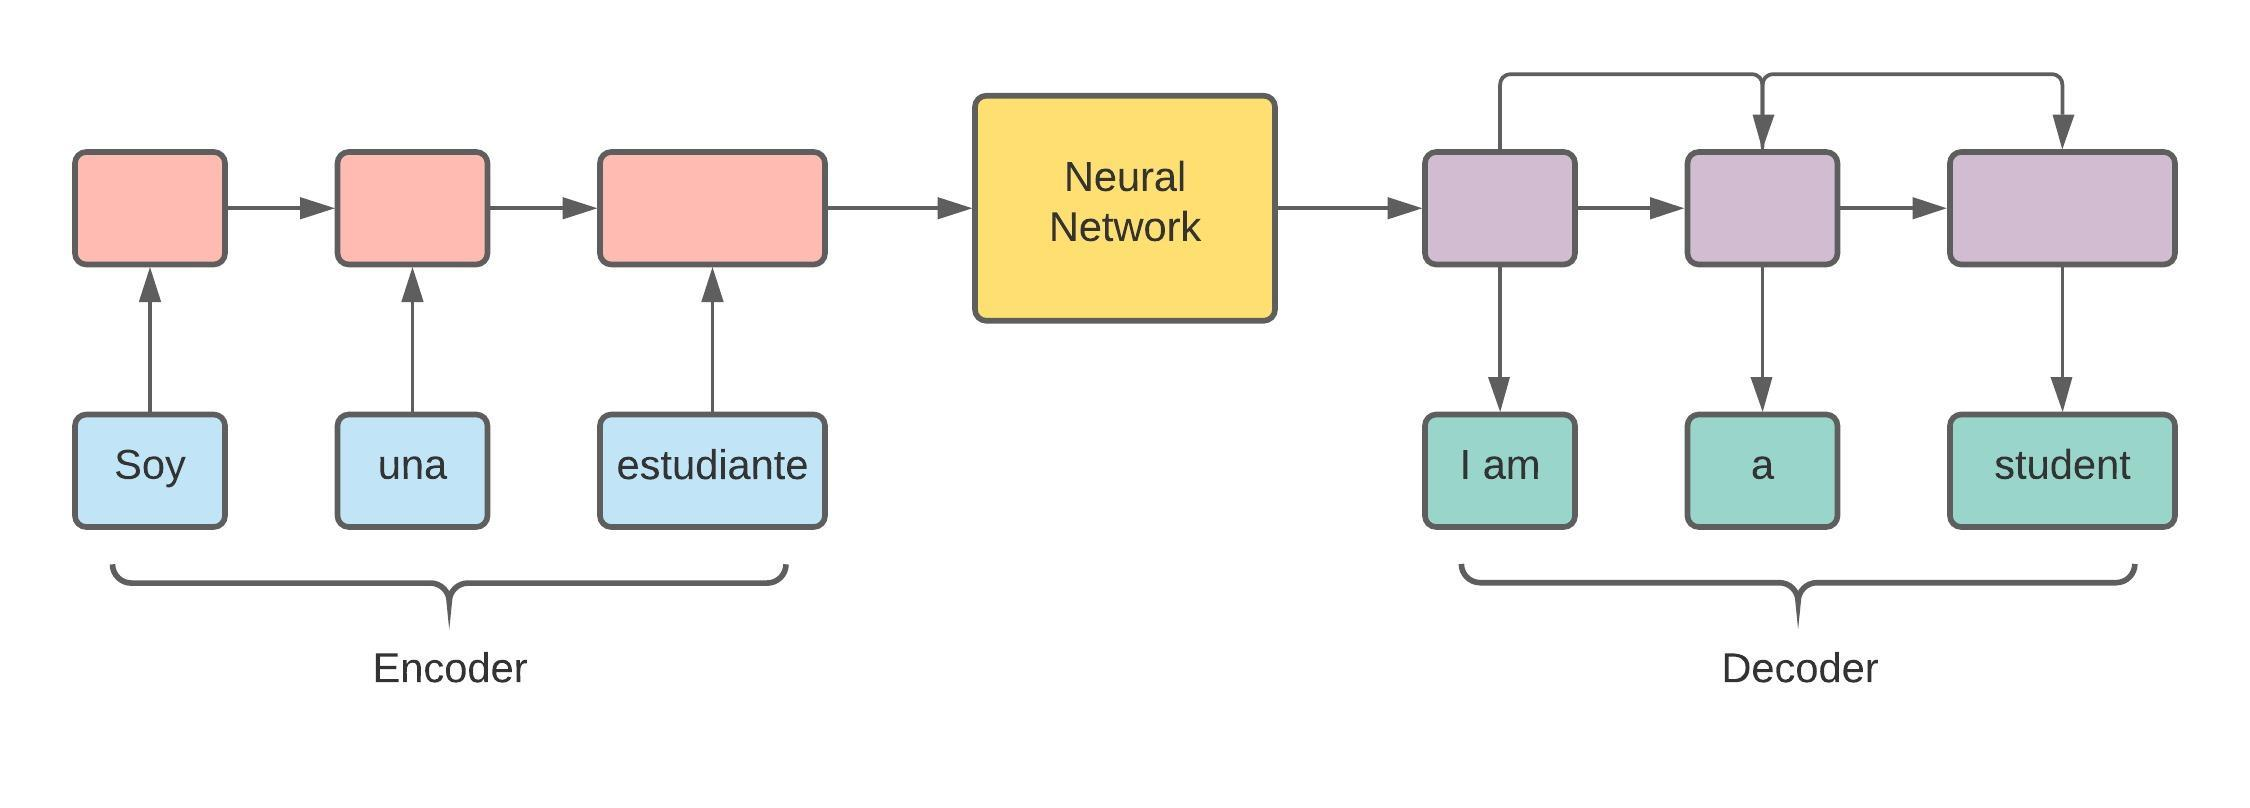

Before the text is fed into the encoder, we have to process the text and convert it into a format the neural network can use. First, we clean the text by removing punctuation and converting it to lowercase. Then, we use a tokenizer to map each word to an integer. Each language has its own tokenizer. After each sequence of words is converted into a sequence of integers, we pad the ends with zeros to ensure each sequence is of the same length. Finally, we can run the sequence through the neural network.

Our resulting output is also a sequence of integers. However, we can't immediately use our tokenizer to convert it into a sequence of words. The neural network took each word from the input sequence and determined the probability it's equivalent to any of the word-integers in our output language vocabulary. The word-integer with the highest probability is what we choose as our translation. We can now use the output language's tokenizer to map the integer back to the word and get our full translation.

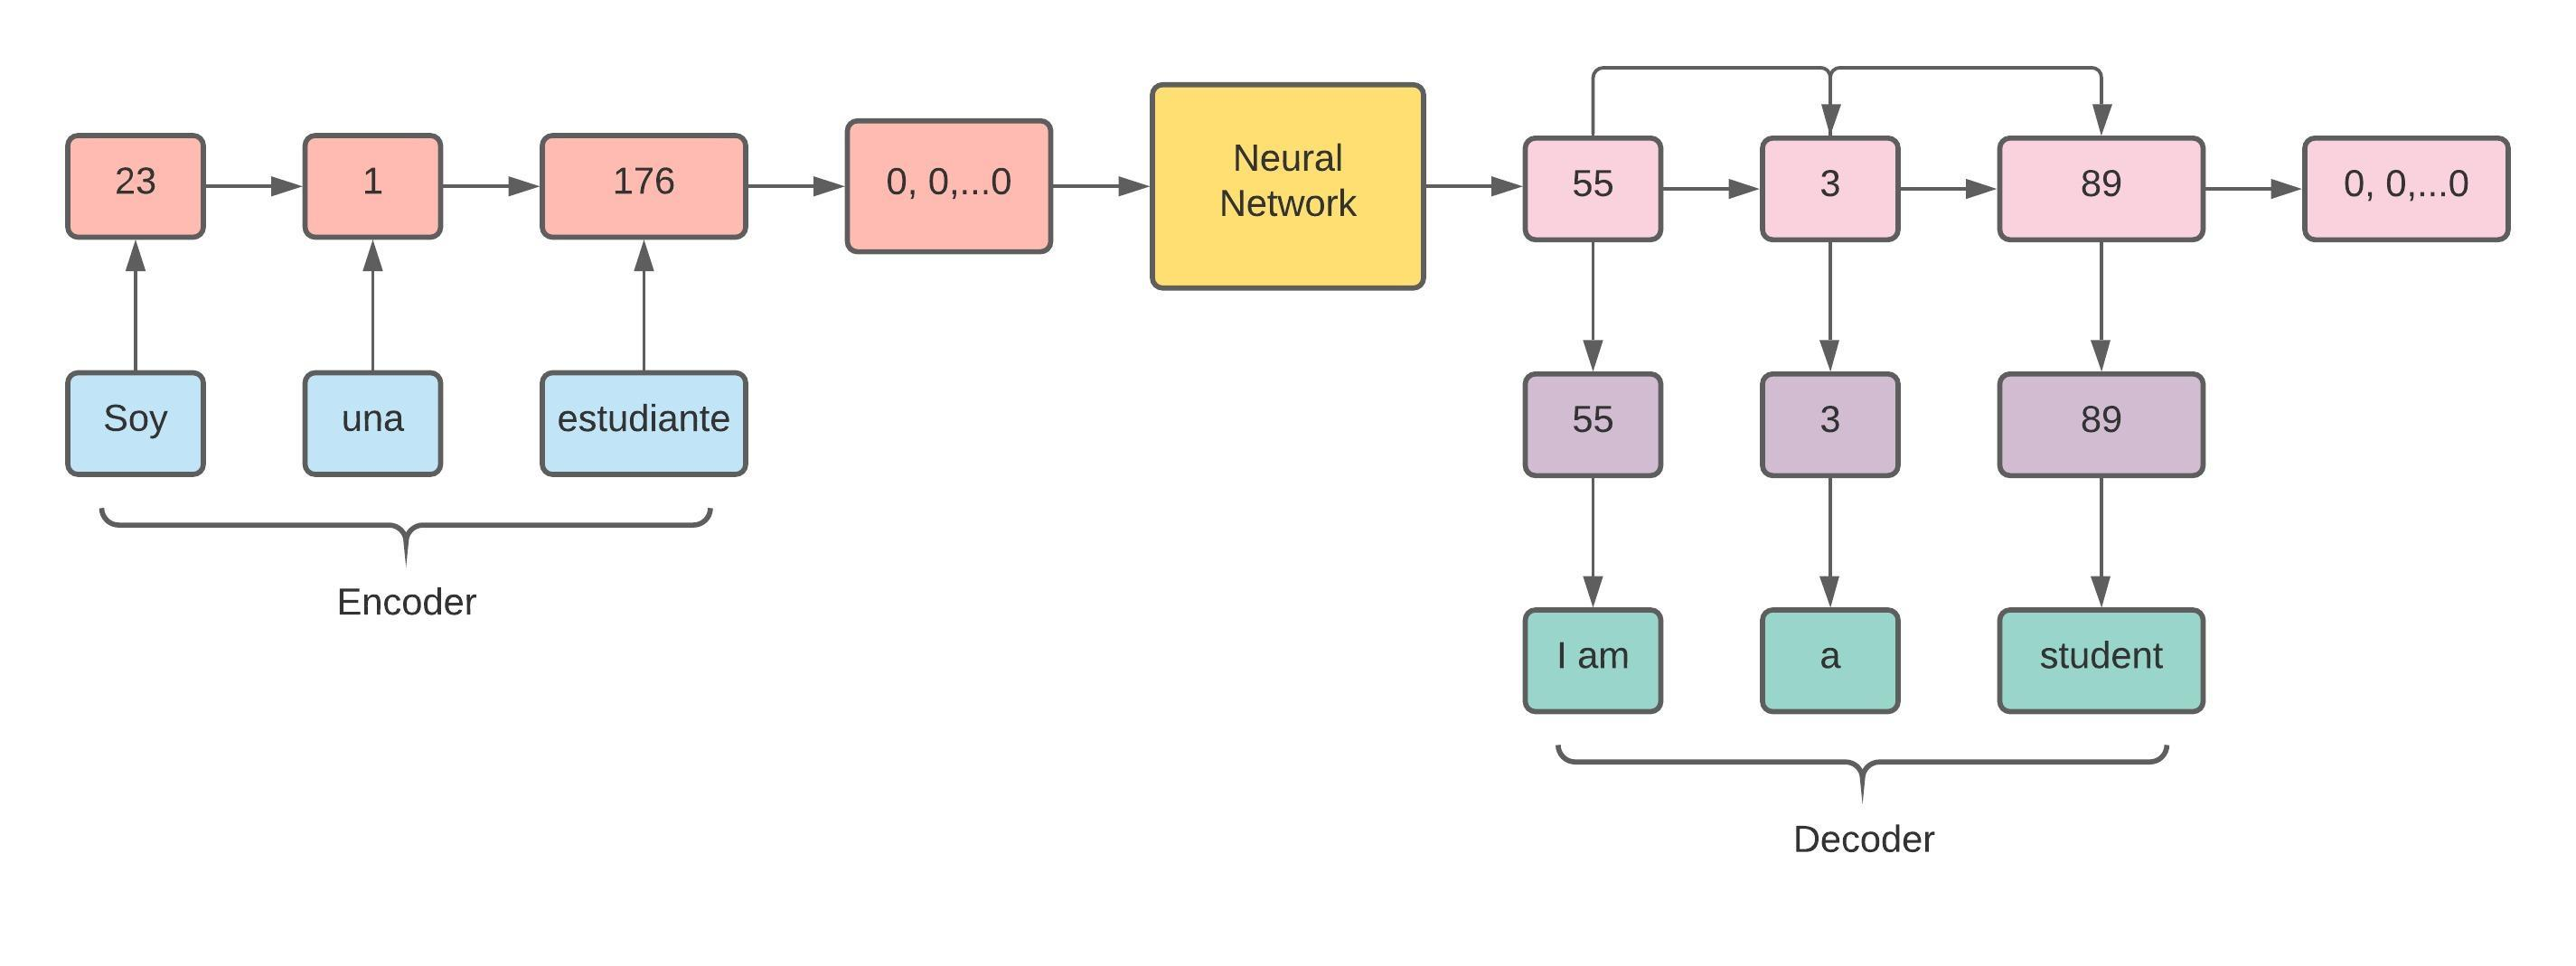

###Libraries Used

* Spark/PySpark
* Tensorflow/Keras 
* Numpy
* Pandas
* Scikit-learn

###Supported Translations


*   Spanish to English
*   English to Spanish
*   French to English
*   English to French

#Code


---



### Setup

Install and configure Spark

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyarrow==1.0.0

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/

In [ ]:
# Set Spark environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Find Spark and import necessary PySpark libraries
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_replace, lower, explode
from pyspark.ml import Pipeline, Transformer

# Create Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

Download data files from Anki

In [ ]:
!wget -q http://www.manythings.org/anki/spa-eng.zip
!wget -q http://www.manythings.org/anki/fra-eng.zip
!unzip -o spa-eng.zip
!unzip -o fra-eng.zip
!mkdir data
!mkdir data/text
!mv spa.txt data/text/spanish.txt
!mv fra.txt data/text/french.txt

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


Import necessary libraries

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import array
import time
import re
import random
% matplotlib inline

###What we're all here for

#####Spark Dataframe 

Read, transform, create, split

In [ ]:
FILE_PREFIX = 'data/text/'
PARQUET_PREFIX = 'data/parquet/'

# Read language pair translations from .txt file into Spark dataframe
def read_dataframe(X, y):
    print("Creating dataframe")
    parquet_file_name = PARQUET_PREFIX + X + "_" + y
    if X != 'english':
        file_name = FILE_PREFIX + X + ".txt"
        schema = StructType([StructField("y", StringType(), True), StructField("X", StringType(), True),
                             StructField("Misc", StringType(), True)])
    else:
        file_name = FILE_PREFIX + y + ".txt"
        schema = StructType([StructField("X", StringType(), True), StructField("y", StringType(), True),
                             StructField("Misc", StringType(), True)])
    df = spark.read.option("header", "false").option("delimiter", "\\t").schema(schema).csv(file_name).select('X', 'y')
    df.write.format("parquet").mode("overwrite").save(parquet_file_name)
    df = spark.read.load(parquet_file_name)
    return df

# Clean and tokenize dataframe
def transform_dataframe(df):
    cleaner = Cleaner()
    tokenizer = Tokenizer()
    stages = [cleaner, tokenizer]
    pipe = Pipeline(stages=stages).fit(df)
    df = pipe.transform(df)
    return df, tokenizer

# Combines read_dataframe and transform_dataframe functions for convenience
def create_dataframe(X, y):
    X = X.lower()
    y = y.lower()
    df = read_dataframe(X, y)
    df, tokenizer = transform_dataframe(df)
    return df, tokenizer

# Splits tensors into training and testing sets
def train_test(tokenizer):
    X_tensor = tokenizer.get_X_tensor()
    y_tensor = tokenizer.get_y_tensor()
    return train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=2020)


#####Transformers

Dataframe preprocessing

In [ ]:
LANGUAGES = ['X', 'y']

# Cleans dataset by changing case to lowercase and removing punctuation
class Cleaner(Transformer):
    def _transform(self, df: DataFrame) -> DataFrame:
        print("Cleaning")
        for language in LANGUAGES:
            df = df.withColumn(language + '_cleaned', regexp_replace(language, "([?.!,¿¡])", r""))
            df = df.withColumn(language + '_cleaned', regexp_replace(language + '_cleaned', r'[" "]+', " ", ))
            df = df.withColumn(language + '_cleaned', lower(df[language + '_cleaned']))
        return df

# Tokenizes dataset 
# X/y_tokenizer builds vocabulary for language X/y by mapping each word to a unique integer
# X/y_tensor represents each sentence in language X/y based on mapping
class Tokenizer(Transformer):
    def __init__(self, X_tensor=None, y_tensor=None, X_tokenizer=None, y_tokenizer=None):
        self.X_tensor = X_tensor
        self.y_tensor = y_tensor
        self.X_tokenizer = X_tokenizer
        self.y_tokenizer = y_tokenizer
    
    def get_X_tensor(self):
        return self.X_tensor
  
    def get_y_tensor(self):
        return self.y_tensor 

    def get_X_tokenizer(self):
        return self.X_tokenizer

    def get_y_tokenizer(self):
        return self.y_tokenizer

    def set_X_tokenizer(self, X_tokenizer):
        self.X_tokenizer = X_tokenizer

    def set_y_tokenizer(self, y_tokenizer):
        self.y_tokenizer = y_tokenizer

    def set_X_tensor(self, tensor):
        self.X_tensor = tensor
  
    def set_y_tensor(self, tensor):
        self.y_tensor = tensor  

    def set_parameters(self, X_tensor, y_tensor, X_tokenizer, y_tokenizer):
        self.set_X_tokenizer(X_tokenizer)
        self.set_y_tokenizer(y_tokenizer)
        self.set_X_tensor(X_tensor)
        self.set_y_tensor(y_tensor)
      
    def join_dfs(self, df:DataFrame) -> DataFrame:
        tensor_pd = pd.DataFrame([tuple(self.X_tensor), tuple(self.y_tensor)]).transpose()
        tensor_pd = tensor_pd.applymap(lambda x: array.array('i', x))
        pd_df = df.toPandas().join(tensor_pd)
        schema = StructType([StructField("X", StringType(), True), StructField("y", StringType(), True), StructField("X_cleaned", StringType(), True), StructField("y_cleaned", StringType(), True), StructField("X_tensor", ArrayType(IntegerType()), True), StructField("y_tensor", ArrayType(IntegerType()), True)])
        df = spark.createDataFrame(data=pd_df, schema=schema)
        return df
    
    def _transform(self, df:DataFrame) -> DataFrame:
        print("Tokenizing")
        pd_clean = df.select(LANGUAGES[0] + "_cleaned", LANGUAGES[1] + "_cleaned").toPandas()
        X_tokenizer = text.Tokenizer(filters='')
        X_tokenizer.fit_on_texts(pd_clean[LANGUAGES[0] + "_cleaned"])
        X_tensor = X_tokenizer.texts_to_sequences(pd_clean[LANGUAGES[0] + "_cleaned"])
        X_tensor = sequence.pad_sequences(X_tensor, padding='post')
        y_tokenizer = text.Tokenizer(filters='')
        y_tokenizer.fit_on_texts(pd_clean[LANGUAGES[1] + "_cleaned"])
        y_tensor = y_tokenizer.texts_to_sequences(pd_clean[LANGUAGES[1] + "_cleaned"])
        y_tensor = sequence.pad_sequences(y_tensor, padding='post')
        self.set_parameters(X_tensor, y_tensor, X_tokenizer, y_tokenizer)
        df = self.join_dfs(df)
        return df

#####Keras Neural Network Model

Define, train, test, and evaluate model

In [ ]:
# Constants
CHECKPOINT = 'models/'
UNITS = 512
EPOCHS = 30
LEARNING_RATE = 0.001
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']
OPTIMIZER = optimizers.RMSprop(lr=LEARNING_RATE)
MINUTES_PER_HOUR = 60

strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync


class Model:
    def __init__(self, X, y, tokenizer, model=None, history=None):
        self.X = X.lower()
        self.y = y.lower()
        self.tokenizer = tokenizer
        self.model = model
        self.history = history

    def set_model(self, model):
        self.model = model

    def set_history(self, history):
        self.history = history

    def define_model(self, units=UNITS, optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS):
        print("Defining model")
        X_vocab_size = len(self.tokenizer.get_X_tokenizer().word_index) + 1
        y_vocab_size = len(self.tokenizer.get_y_tokenizer().word_index) + 1
        max_X_length = self.tokenizer.get_X_tensor().shape[1]
        max_y_length = self.tokenizer.get_y_tensor().shape[1]
        model = Sequential()
        model.add(Embedding(X_vocab_size, units, input_length=max_X_length, mask_zero=True))
        model.add(LSTM(units))
        model.add(RepeatVector(max_y_length))
        model.add(LSTM(units, return_sequences=True))
        model.add(Dense(y_vocab_size, activation='softmax'))
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.set_model(model)
        return model

    def train_model(self, X_train, y_train, epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, validation_split=0.1):
        print("Begin training model")
        checkpoint_name = '.'.join([self.X, self.y])
        checkpoint_name = ''.join([CHECKPOINT, checkpoint_name])
        checkpoint = ModelCheckpoint(checkpoint_name, monitor='accuracy', verbose=verbose, save_best_only=True, mode='max')
        start = time.time()
        history = self.model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), epochs=epochs,
                                 batch_size=batch_size, validation_split=validation_split, verbose=verbose,
                                 callbacks=[checkpoint])
        end = time.time()
        elapsed_time = end - start
        print("Elapsed time: {} minutes".format(elapsed_time/MINUTES_PER_HOUR))
        self.set_model(self.model)
        self.set_history(history)
        return history

    def test_model(self, X_test, y_test):
        print("Testing model")
        test_metrics = self.model.evaluate(X_test, y_test, verbose=1)
        return test_metrics

    def graph_metrics(self, history=None):
      if self.history is not None or history is not None:
        print(history.history)
        print("Accuracy")
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.legend(['train','validation'])
        plt.show()
        print("Loss")
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.legend(['train','validation'])
        plt.show()       

    def run_model(self, X_train, y_train, X_test, y_test):
      with strategy.scope():
        keras_model = self.define_model()
      keras_model.summary()
      history = self.train_model(X_train, y_train)
      self.graph_metrics(history)
      test_metrics = self.test_model(X_test, y_test)
      print("Test Metrics")
      print("loss: {}, accuracy: {} on test set".format(test_metrics[0], test_metrics[1]))
      return keras_model


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


#####Translator

Translates between:
*   string in language X to string in language y
*   string in language X to tensor in language X
*   tensor in language X to string in language X

In [ ]:
class Translator:
    def __init__(self, X, y, model, tokenizer):
        self.model = model
        self.X = X.lower()
        self.y = y.lower()
        self.tokenizer = tokenizer

    # string in language X to string in language y
    def translate(self, tensor):
        max_X_length = self.tokenizer.get_X_tensor().shape[1]
        if type(tensor) != np.ndarray:
          tensor = self.string_to_tensor(tensor, self.X)
          tensor = np.pad(tensor, (0, max_X_length - len(tensor)), 'constant', constant_values=[0])
        tensor = tensor.reshape(1, max_X_length)
        prediction = np.argmax(self.model.predict(tensor), axis=-1)
        return self.decode_tensor(prediction[0], self.y)

    # tensor in language X to string in language X
    def decode_tensor(self, tensor, language):
        if language.lower() == self.X:
            tokenizer = self.tokenizer.get_X_tokenizer()
        else:
            tokenizer = self.tokenizer.get_y_tokenizer()
        return ' '.join([tokenizer.index_word[word] for word in tensor if word != 0])

    # string in language X to tensor in language X
    def string_to_tensor(self, phrase, language):
        phrase = re.sub(r"[?.!,¿¡]", r"", phrase).lower()
        if language.lower() == self.X:
            tokenizer = self.tokenizer.get_X_tokenizer()
        else:
            tokenizer = self.tokenizer.get_y_tokenizer()
        tensor = [tokenizer.word_index[word] for word in phrase.split(' ') if word in tokenizer.word_index]
        return tensor

    def compare_translations(self, X_test, y_test):
      X_test_strings = [translator.decode_tensor(x, self.X) for x in X_test]
      y_test_strings = [translator.decode_tensor(y, self.y) for y in y_test]
      prediction_tensors = np.argmax(self.model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1)), axis=-1)
      predictions = [self.decode_tensor(tensor, self.y) for tensor in prediction_tensors]
      schema = StructType([StructField(self.X, StringType(), True), StructField(self.y, StringType(), True), StructField('Prediction', StringType(), True)])
      predictions_pd_df = pd.DataFrame([X_test_strings, y_test_strings, predictions]).transpose()
      prediction_df = spark.createDataFrame(data=predictions_pd_df, schema=schema)
      return prediction_df

####Model Training

In [ ]:
def run(X, y):
    X = X.lower()
    y = y.lower()
    df, tokenizer = create_dataframe(X, y)
    df.show()
    print("Total number of examples: {}\n".format(df.count()))

    print("{} vocabulary size: {}".format(X, len(tokenizer.get_X_tokenizer().word_index) + 1))
    print("Maximum {} sentence length: {}\n".format(X, tokenizer.get_X_tensor().shape[1]))

    print("{} vocabulary size: {}".format(y, len(tokenizer.get_y_tokenizer().word_index) + 1))
    print("Maximum {} sentence length: {}".format(y, tokenizer.get_y_tensor().shape[1]))

    X_train, X_test, y_train, y_test = train_test(tokenizer)
    model = Model(X, y, tokenizer)
    keras_model = model.run_model(X_train, y_train, X_test, y_test)
    translator = Translator(X, y, keras_model, tokenizer)
    prediction_df = translator.compare_translations(X_test[0:10], y_test[0:10])
    prediction_df.show(truncate=False)

#####Spanish to English

Creating dataframe
Cleaning
Tokenizing
+-------------------+-----+---------------+---------+--------------------+--------------------+
|                  X|    y|      X_cleaned|y_cleaned|            X_tensor|            y_tensor|
+-------------------+-----+---------------+---------+--------------------+--------------------+
|                Ve.|  Go.|             ve|       go|[370, 0, 0, 0, 0,...|[40, 0, 0, 0, 0, ...|
|              Vete.|  Go.|           vete|       go|[1404, 0, 0, 0, 0...|[40, 0, 0, 0, 0, ...|
|              Vaya.|  Go.|           vaya|       go|[485, 0, 0, 0, 0,...|[40, 0, 0, 0, 0, ...|
|            Váyase.|  Go.|         váyase|       go|[5213, 0, 0, 0, 0...|[40, 0, 0, 0, 0, ...|
|              Hola.|  Hi.|           hola|       hi|[2055, 0, 0, 0, 0...|[2279, 0, 0, 0, 0...|
|            ¡Corre!| Run!|          corre|      run|[1691, 0, 0, 0, 0...|[447, 0, 0, 0, 0,...|
|           ¡Corran!| Run!|         corran|      run|[7953, 0, 0, 0, 0...|[447, 0, 0, 0, 0,...|
|

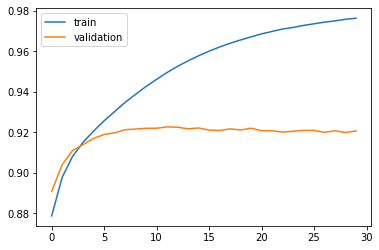

Loss


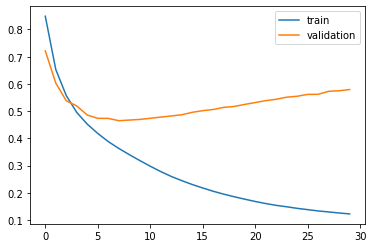

Testing model
1/1 [==============================] - 0s 2ms/step - loss: 0.3907 - accuracy: 0.9447
Test Metrics
loss: 0.39065802097320557, accuracy: 0.9446808695793152 on test set


In [ ]:
run('spanish', 'english')

#####English to Spanish

Creating dataframe
Cleaning
Tokenizing
+-----+-------------------+---------+---------------+--------------------+--------------------+
|    X|                  y|X_cleaned|      y_cleaned|            X_tensor|            y_tensor|
+-----+-------------------+---------+---------------+--------------------+--------------------+
|  Go.|                Ve.|       go|             ve|[40, 0, 0, 0, 0, ...|[370, 0, 0, 0, 0,...|
|  Go.|              Vete.|       go|           vete|[40, 0, 0, 0, 0, ...|[1404, 0, 0, 0, 0...|
|  Go.|              Vaya.|       go|           vaya|[40, 0, 0, 0, 0, ...|[485, 0, 0, 0, 0,...|
|  Go.|            Váyase.|       go|         váyase|[40, 0, 0, 0, 0, ...|[5213, 0, 0, 0, 0...|
|  Hi.|              Hola.|       hi|           hola|[2279, 0, 0, 0, 0...|[2055, 0, 0, 0, 0...|
| Run!|            ¡Corre!|      run|          corre|[447, 0, 0, 0, 0,...|[1691, 0, 0, 0, 0...|
| Run!|           ¡Corran!|      run|         corran|[447, 0, 0, 0, 0,...|[7953, 0, 0, 0, 0...|
|

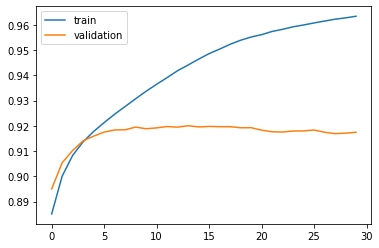

Loss


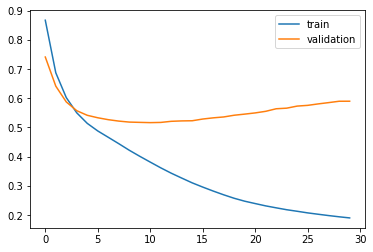

Testing model
1/1 [==============================] - 0s 1ms/step - loss: 0.3889 - accuracy: 0.9306
Test Metrics
loss: 0.3889079988002777, accuracy: 0.9306122660636902 on test set
+-------------------------------------------------------+----------------------------------------------------+---------------------------------------------+
|Spanish                                                |English                                             |Prediction                                   |
+-------------------------------------------------------+----------------------------------------------------+---------------------------------------------+
|do you have any more big ones                          |tiene algunos más grandes                           |tienes más grandes secreto                   |
|shooting stars are meteorites                          |las estrellas fugaces son meteoritos                |las estrellas es                             |
|everybody was looking for tom      

In [ ]:
run('english', 'spanish')

#####French to English

In [ ]:
X = 'French'
y = 'English'
run(X, y)

Creating dataframe
Cleaning
Tokenizing
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   X|                   y|           X_cleaned|           y_cleaned|            X_tensor|            y_tensor|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Nous avons discut...|We've discussed a...|nous avons discut...|we've discussed a...|[17, 87, 2093, 2,...|[368, 1894, 5, 12...|
|Nous avons déjà f...|We've faced this ...|nous avons déjà f...|we've faced this ...|[17, 87, 156, 37,...|[368, 3911, 13, 2...|
|Nous avons déjà é...|We've faced this ...|nous avons déjà é...|we've faced this ...|[17, 87, 156, 59,...|[368, 3911, 13, 2...|
|Nous avons regard...|We've looked at a...|nous avons regard...|we've looked at a...|[17, 87, 851, 83,...|[368, 412, 39, 5,...|
|Nous avons perdu ...|We've lost three ...|nous avons perdu ...|w

#####English to French

In [ ]:
X = 'English'
y = 'French'
run(X, y)

#Demo

---



Two modes available:


*   Train - highly recommended to run on GPU unless you have the patience of a saint
  1.   Create, clean, and tokenize dataframe
  2.   Train model
  3.   Test model on small subset of test set - not enough RAM to test on entire set because neural network only accepts NumPy arrays
  
*   Translate - using same model as in training mode, but you don't have to wait for the training to finish
  1. Create, clean, and tokenize dataframe
  2. Enter phrase in given language
  3. Pretrained model will translate
    **Note:** Pretrained models must be in same directory as this notebook for this to work.


In [ ]:
def training_mode(X, y, tokenizer):
    X_train, X_test, y_train, y_test = train_test(tokenizer)
    model = Model(X, y, tokenizer)
    keras_model = model.run_model(X_train, y_train, X_test, y_test)
    translator = Translator(X, y, keras_model, tokenizer)
    return translator.compare_translations(X_test[0:5], y_test[0:5])

def translating_mode(X, y, phrase, tokenizer):
    model_name = ''.join([CHECKPOINT, '.'.join([X, y])])
    trained_model = load_model(model_name)
    translator = Translator(X, y, trained_model, tokenizer)
    return translator.translate(phrase)

In [ ]:
print("The following translators are available.\n")
print('Spanish to English\tEnglish to Spanish')
print('French to English\tEnglish to French')
X = input("\nPlease choose a language to translate from.\n")
y = input("\nPlease choose a language to translate to.\n")

print("\nSelection: {} to {}\n".format(X, y))
df, tokenizer = create_dataframe(X.lower(), y.lower())
print("\nTotal number of examples: {}\n".format(len(tokenizer.get_X_tensor())))

print("{} vocabulary size: {}".format(X, len(tokenizer.get_X_tokenizer().word_index) + 1))
print("Maximum {} sentence length: {}\n".format(X, tokenizer.get_X_tensor().shape[1]))

print("{} vocabulary size: {}".format(y, len(tokenizer.get_y_tokenizer().word_index) + 1))
print("Maximum {} sentence length: {}\n".format(y, tokenizer.get_y_tensor().shape[1]))

print("Would you like to see the full training process or skip to the translation part?") 
selection = input("Please enter 'train' for the former or 'translate' for the latter.\n")
if selection.lower() == 'train':
    print("\nMode: Training\n")
    prediction_df = training_mode(X.lower(), y.lower(), tokenizer)
    prediction_df.show(truncate=False)
elif selection.lower() == 'translate':
    continue_translating = True
    print("\nMode: Translate\n")
    while continue_translating:
        phrase = input("Please enter a phrase to translate.\n")
        translation = translating_mode(X.lower(), y.lower(), phrase, tokenizer)
        print("You entered: {}".format(phrase))
        print("{} in {} is {}".format(phrase, y, translation))
        continue_translating = True if input(
            "Would you like to translate another phrase?\n").lower() == 'yes' else False


#Playground


---



Play around with the different translation models without having to wait for the models to finish training.

**Note:** The pretrained models must be in the same directory as this notebook for this to work.

Change `X` and `y` to signify the languge you want to translate from and the language you want to translate to, respectively.



















In [ ]:
X = 'Spanish'
y = 'English'
df, tokenizer = create_dataframe(X, y)
df.show()

Creating dataframe
Cleaning
Tokenizing
+-------------------+-----+---------------+---------+--------------------+--------------------+
|                  X|    y|      X_cleaned|y_cleaned|            X_tensor|            y_tensor|
+-------------------+-----+---------------+---------+--------------------+--------------------+
|                Ve.|  Go.|             ve|       go|[370, 0, 0, 0, 0,...|[40, 0, 0, 0, 0, ...|
|              Vete.|  Go.|           vete|       go|[1404, 0, 0, 0, 0...|[40, 0, 0, 0, 0, ...|
|              Vaya.|  Go.|           vaya|       go|[485, 0, 0, 0, 0,...|[40, 0, 0, 0, 0, ...|
|            Váyase.|  Go.|         váyase|       go|[5213, 0, 0, 0, 0...|[40, 0, 0, 0, 0, ...|
|              Hola.|  Hi.|           hola|       hi|[2055, 0, 0, 0, 0...|[2279, 0, 0, 0, 0...|
|            ¡Corre!| Run!|          corre|      run|[1691, 0, 0, 0, 0...|[447, 0, 0, 0, 0,...|
|           ¡Corran!| Run!|         corran|      run|[7953, 0, 0, 0, 0...|[447, 0, 0, 0, 0,...|
|

Run the cell below to see some statistics about our dataset.

In [ ]:
print("Total number of examples: {}\n".format(df.count()))

print("{} vocabulary size: {}".format(X, len(tokenizer.get_X_tokenizer().word_index) + 1))
print("Maximum {} sentence length: {}\n".format(X, tokenizer.get_X_tensor().shape[1]))

print("{} vocabulary size: {}".format(y, len(tokenizer.get_y_tokenizer().word_index) + 1))
print("Maximum {} sentence length: {}".format(y, tokenizer.get_y_tensor().shape[1]))

Total number of examples: 124325

Spanish vocabulary size: 26677
Maximum Spanish sentence length: 49

English vocabulary size: 13987
Maximum English sentence length: 47


Let's load our model now. 

In [ ]:
model_name = "models/" + '.'.join([X.lower(), y.lower()])
keras_model = load_model(model_name)
keras_model.summary()
translator = Translator(X.lower(), y.lower(), keras_model, tokenizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 512)           13658624  
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 47, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 47, 512)           2099200   
_________________________________________________________________
dense (Dense)                (None, 47, 13987)         7175331   
Total params: 25,032,355
Trainable params: 25,032,355
Non-trainable params: 0
_________________________________________________________________


Change `phrase` to what you want to translate, and then run the cell.

In [ ]:
phrase = "Me gustan los perros"
translation = translator.translate(phrase)
print("{} in {} is {}".format(phrase, y, translation))

Me gustan los perros in English is i like dogs


Alternatively, play around with examples chosen randomly from the dataframe. Change `index` to indicate how many examples to sample.

---



In [ ]:
index = 10
df_sample = df.sample(0.1, random.randint(1, 2020)).select('X', 'y', 'X_tensor', 'y_tensor').limit(index)
X_tensor = df_sample.select(explode(df['X_tensor'])).toPandas().values.reshape(index, -1)
y_tensor = df_sample.select(explode(df['y_tensor'])).toPandas().values.reshape(index, -1)
df_sample_predictions = translator.compare_translations(X_tensor, y_tensor)
df_sample_predictions.show(truncate=False)

+------------+-------+-----------+
|spanish     |english|Prediction |
+------------+-------+-----------+
|vete        |go     |go         |
|auxilio     |help   |help       |
|parad       |stop   |stop stop  |
|me escondí  |i hid  |i hid      |
|disparad    |shoot  |fire       |
|dispara     |shoot  |shoot      |
|él corrió   |he ran |he ran     |
|no puede ser|no way |it can't be|
|imposible   |no way |no way     |
|sé justo    |be fair|be fair    |
+------------+-------+-----------+

